# Análise de Performance do Servidor Online Boutique

Este notebook analisa a performance do servidor durante um teste de carga de 10 segundos com 200 usuários simultâneos.

## Métricas Analisadas:
- **Latência**: Tempo de resposta das requisições
- **Throughput**: Requisições por segundo
- **Uso de CPU**: Consumo de recursos do servidor
- **Escalabilidade**: Máximo de réplicas do HPA (Horizontal Pod Autoscaler)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuração do estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


## 1. Carregamento dos Dados


In [30]:
# Carregar dados do Locust
locust_stats = pd.read_csv('results/monolith/locust/monolith_run_stats.csv')
locust_history = pd.read_csv('results/monolith/locust/monolith_run_stats_history.csv')

# Carregar dados de métricas do servidor
hpa_max = pd.read_csv('results/monolith/cpu_hpa/hpa_max.csv')
hpa_current = pd.read_csv('results/monolith/cpu_hpa/hpa_current.csv')
hpa_desired = pd.read_csv('results/monolith/cpu_hpa/hpa_desired.csv')
cpu_pod = pd.read_csv('results/monolith/cpu_hpa/cpu_pod_long.csv')

print("Dados carregados com sucesso!")
print(f"Locust Stats: {len(locust_stats)} linhas")
print(f"Locust History: {len(locust_history)} linhas")
print(f"HPA Max: {len(hpa_max)} linhas")
print(f"HPA Current: {len(hpa_current)} linhas")
print(f"HPA Desired: {len(hpa_desired)} linhas")
print(f"CPU Pod: {len(cpu_pod)} linhas")


Dados carregados com sucesso!
Locust Stats: 12 linhas
Locust History: 896 linhas
HPA Max: 89 linhas
HPA Current: 89 linhas
HPA Desired: 89 linhas
CPU Pod: 89 linhas


## 2. Análise de Latência


=== MÉTRICAS DE LATÊNCIA ===
      Métrica  Tempo (ms)
Mediana (50%)   12.000000
        Média   38.746191
          P95   26.000000
          P99   67.000000
       Máximo 8506.031200


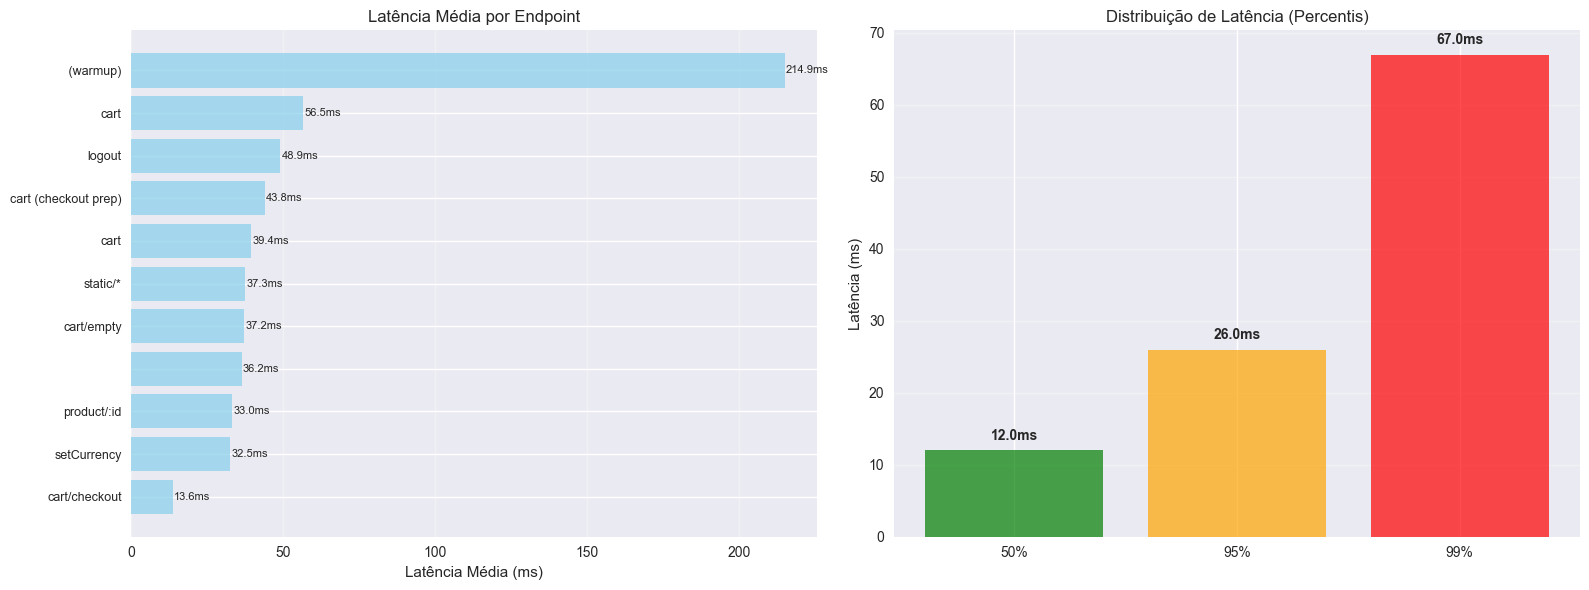

In [31]:
# Filtrar apenas dados agregados do Locust
aggregated_stats = locust_stats[locust_stats['Type'].isna() | (locust_stats['Type'] == '')]

# Extrair métricas de latência
latency_metrics = {
    'Métrica': ['Mediana (50%)', 'Média', 'P95', 'P99', 'Máximo'],
    'Tempo (ms)': [
        aggregated_stats['Median Response Time'].iloc[0],
        aggregated_stats['Average Response Time'].iloc[0],
        aggregated_stats['95%'].iloc[0],
        aggregated_stats['99%'].iloc[0],
        aggregated_stats['Max Response Time'].iloc[0]
    ]
}

latency_df = pd.DataFrame(latency_metrics)
print("=== MÉTRICAS DE LATÊNCIA ===")
print(latency_df.to_string(index=False))

# Gráfico de latência por endpoint
endpoint_stats = locust_stats[locust_stats['Type'].notna() & (locust_stats['Type'] != '')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Latência média por endpoint
endpoint_latency = endpoint_stats.groupby('Name')['Average Response Time'].mean().sort_values(ascending=True)
bars1 = ax1.barh(range(len(endpoint_latency)), endpoint_latency.values, color='skyblue', alpha=0.7)
ax1.set_yticks(range(len(endpoint_latency)))
ax1.set_yticklabels([name.replace('GET /', '').replace('POST /', '') for name in endpoint_latency.index], fontsize=9)
ax1.set_xlabel('Latência Média (ms)')
ax1.set_title('Latência Média por Endpoint')
ax1.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}ms', 
             ha='left', va='center', fontsize=8)

# Gráfico 2: Distribuição de latência (P50, P95, P99)
percentiles = ['50%', '95%', '99%']
percentile_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]

bars2 = ax2.bar(percentiles, percentile_values, color=['green', 'orange', 'red'], alpha=0.7)
ax2.set_ylabel('Latência (ms)')
ax2.set_title('Distribuição de Latência (Percentis)')
ax2.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, percentile_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Análise de Throughput


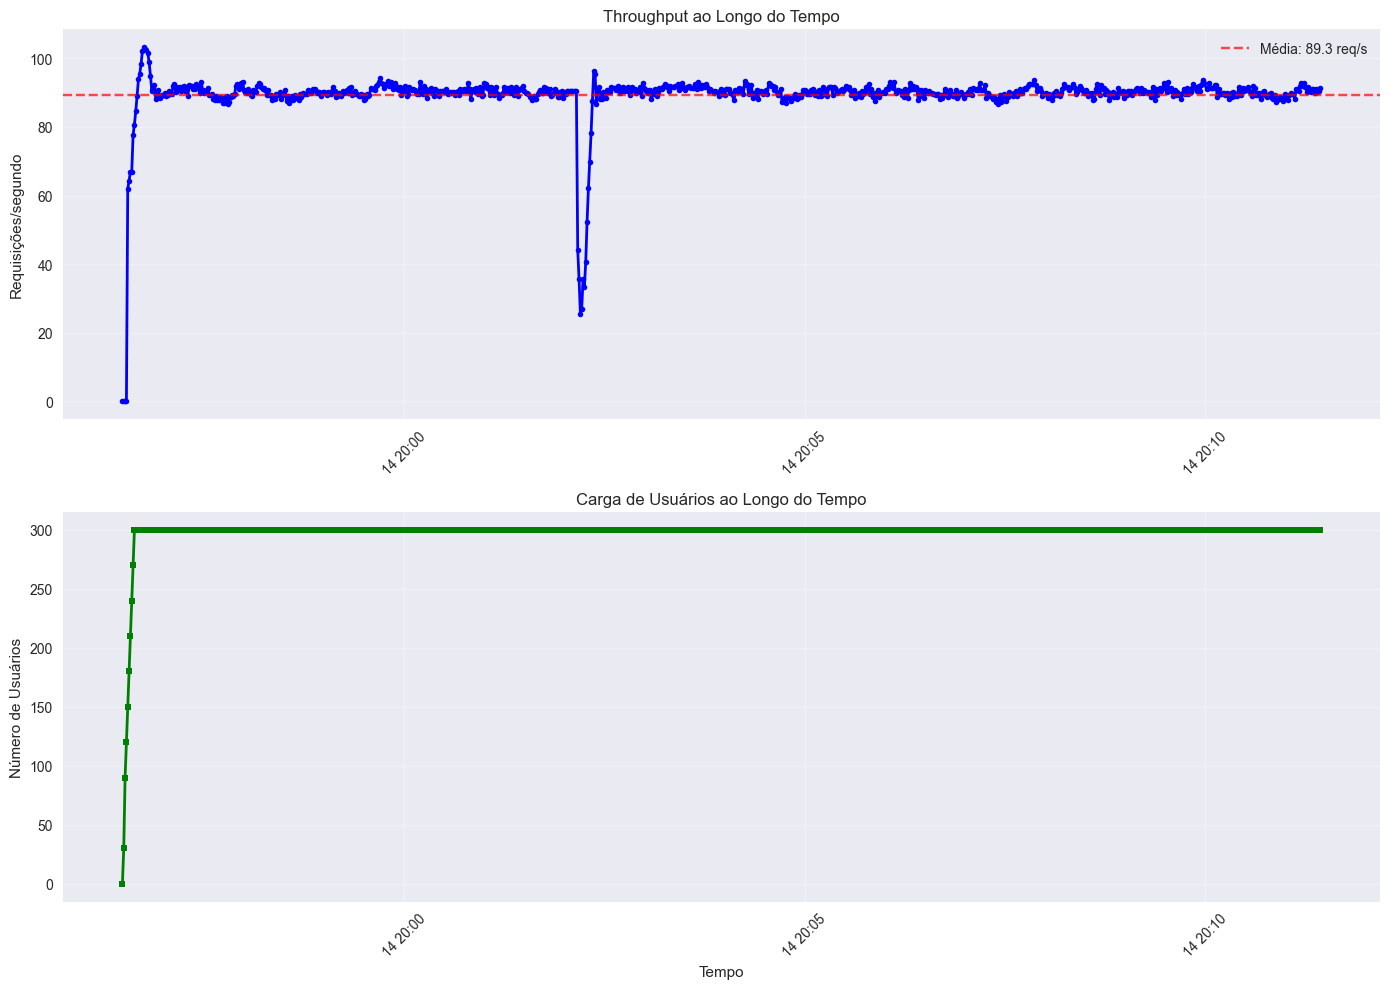

=== ESTATÍSTICAS DE THROUGHPUT ===
Throughput Médio: 89.32 req/s
Throughput Máximo: 103.30 req/s
Throughput Mínimo: 0.00 req/s
Desvio Padrão: 8.32 req/s


In [32]:
# Converter timestamp para datetime
locust_history['datetime'] = pd.to_datetime(locust_history['Timestamp'], unit='s')
hpa_max['datetime'] = pd.to_datetime(hpa_max['timestamp'], unit='s')
hpa_current['datetime'] = pd.to_datetime(hpa_current['timestamp'], unit='s')
hpa_desired['datetime'] = pd.to_datetime(hpa_desired['timestamp'], unit='s')
cpu_pod['datetime'] = pd.to_datetime(cpu_pod['timestamp'], unit='s')

# Filtrar apenas dados agregados do histórico
history_aggregated = locust_history[locust_history['Type'].isna() | (locust_history['Type'] == '')]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Throughput ao longo do tempo
ax1.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', marker='o', markersize=4)
ax1.set_ylabel('Requisições/segundo')
ax1.set_title('Throughput ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de média
avg_throughput = history_aggregated['Requests/s'].mean()
ax1.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_throughput:.1f} req/s')
ax1.legend()

# Gráfico 2: Número de usuários ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['User Count'], 
         linewidth=2, color='green', marker='s', markersize=4)
ax2.set_ylabel('Número de Usuários')
ax2.set_xlabel('Tempo')
ax2.set_title('Carga de Usuários ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas de throughput
print("=== ESTATÍSTICAS DE THROUGHPUT ===")
print(f"Throughput Médio: {avg_throughput:.2f} req/s")
print(f"Throughput Máximo: {history_aggregated['Requests/s'].max():.2f} req/s")
print(f"Throughput Mínimo: {history_aggregated['Requests/s'].min():.2f} req/s")
print(f"Desvio Padrão: {history_aggregated['Requests/s'].std():.2f} req/s")


## 4. Análise de Uso de CPU


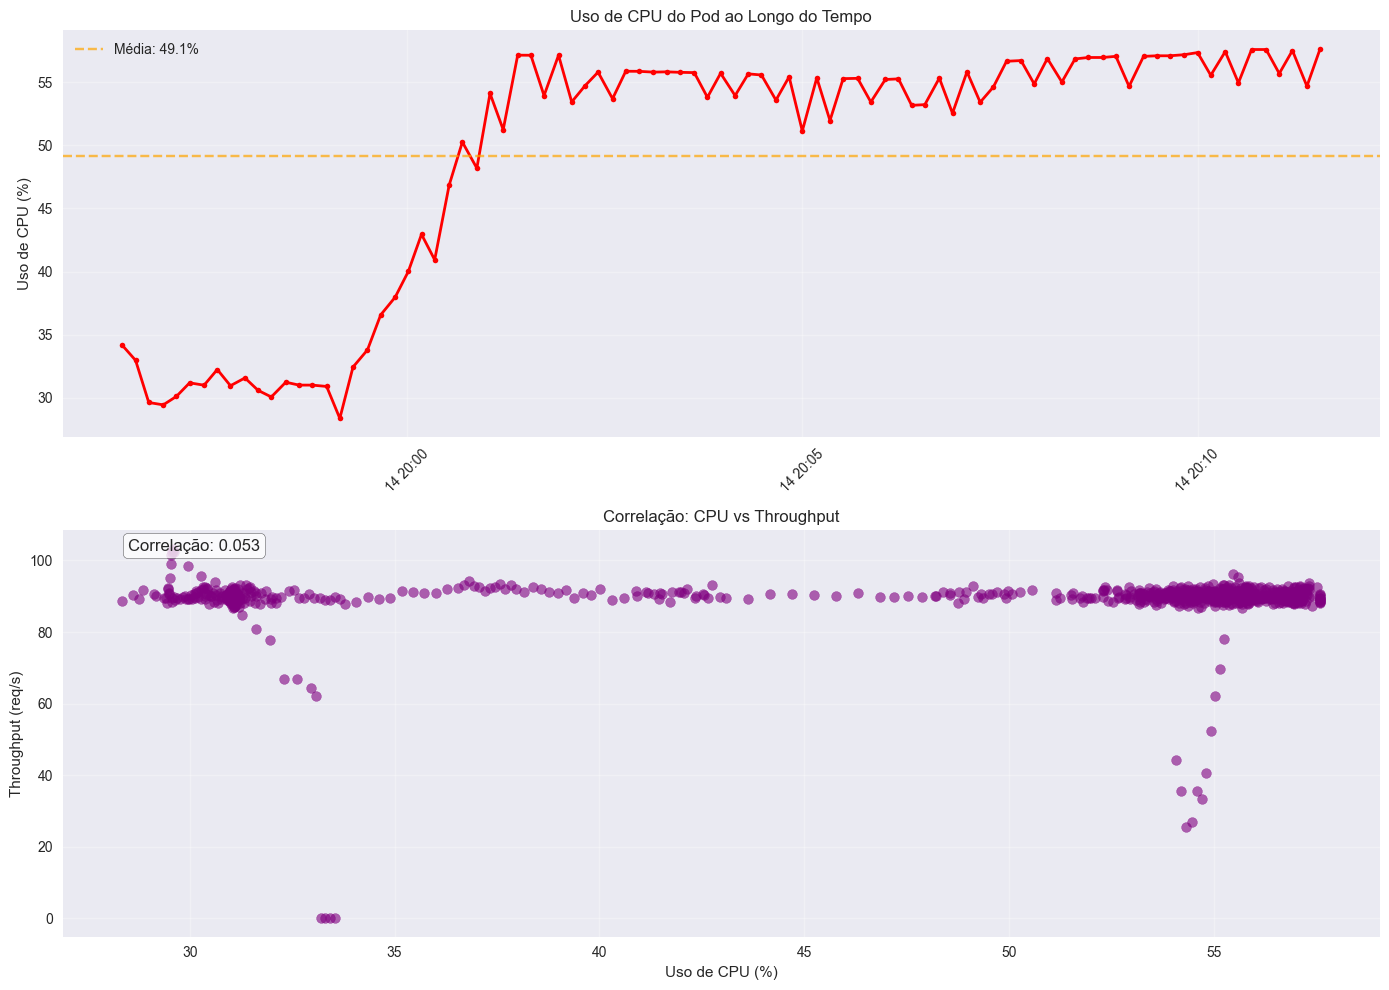

=== ESTATÍSTICAS DE CPU ===
CPU Médio: 49.12%
CPU Máximo: 57.65%
CPU Mínimo: 28.36%
Desvio Padrão: 10.25%
Correlação CPU-Throughput: 0.053


In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Uso de CPU ao longo do tempo
ax1.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', marker='o', markersize=4)
ax1.set_ylabel('Uso de CPU (%)')
ax1.set_title('Uso de CPU do Pod ao Longo do Tempo')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Adicionar linha de média
avg_cpu = cpu_pod['cores'].mean() * 100
ax1.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_cpu:.1f}%')
ax1.legend()

# Gráfico 2: Correlação entre CPU e Throughput
# Interpolar dados para alinhar timestamps
cpu_interp = np.interp(history_aggregated['Timestamp'], 
                      cpu_pod['timestamp'], 
                      cpu_pod['cores'] * 100)

ax2.scatter(cpu_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='purple')
ax2.set_xlabel('Uso de CPU (%)')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correlação: CPU vs Throughput')
ax2.grid(True, alpha=0.3)

# Calcular correlação
correlation = np.corrcoef(cpu_interp, history_aggregated['Requests/s'])[0, 1]
ax2.text(0.05, 0.95, f'Correlação: {correlation:.3f}', 
         transform=ax2.transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estatísticas de CPU
print("=== ESTATÍSTICAS DE CPU ===")
print(f"CPU Médio: {avg_cpu:.2f}%")
print(f"CPU Máximo: {cpu_pod['cores'].max() * 100:.2f}%")
print(f"CPU Mínimo: {cpu_pod['cores'].min() * 100:.2f}%")
print(f"Desvio Padrão: {cpu_pod['cores'].std() * 100:.2f}%")
print(f"Correlação CPU-Throughput: {correlation:.3f}")


## 5. Análise de Escalabilidade (HPA) - Current, Desired e Max Réplicas

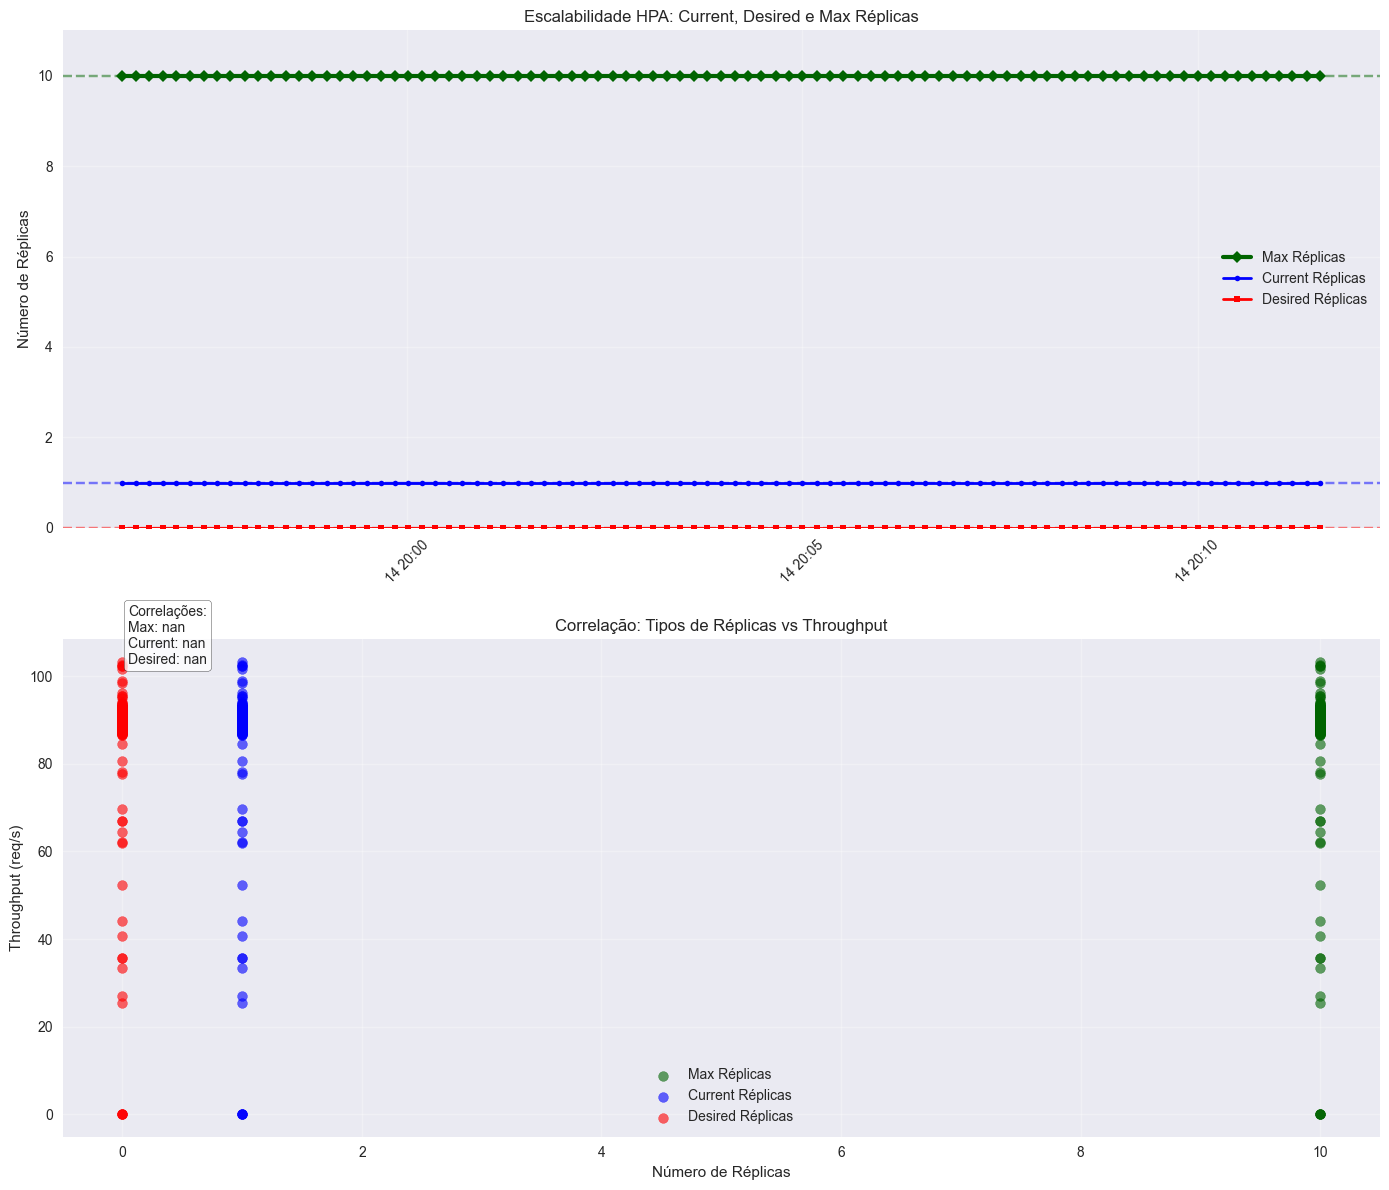

=== ESTATÍSTICAS DE ESCALABILIDADE ===
Max Réplicas - Médio: 10.0, Máximo: 10, Mínimo: 10
Current Réplicas - Médio: 1.0, Máximo: 1, Mínimo: 1
Desired Réplicas - Médio: 0.0, Máximo: 0, Mínimo: 0

Correlações com Throughput:
  • Max Réplicas: nan
  • Current Réplicas: nan
  • Desired Réplicas: nan


In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Gráfico 1: Todas as métricas de réplicas do HPA ao longo do tempo
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max Réplicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current Réplicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired Réplicas')

ax1.set_ylabel('Número de Réplicas')
ax1.set_title('Escalabilidade HPA: Current, Desired e Max Réplicas')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

# Adicionar linhas de média
avg_max = hpa_max['max_replicas'].mean()
avg_current = hpa_current['current_replicas'].mean()
avg_desired = hpa_desired['desired_replicas'].mean()

ax1.axhline(y=avg_max, color='darkgreen', linestyle='--', alpha=0.5, 
           label=f'Max Médio: {avg_max:.1f}')
ax1.axhline(y=avg_current, color='blue', linestyle='--', alpha=0.5, 
           label=f'Current Médio: {avg_current:.1f}')
ax1.axhline(y=avg_desired, color='red', linestyle='--', alpha=0.5, 
           label=f'Desired Médio: {avg_desired:.1f}')

# Gráfico 2: Correlação entre diferentes tipos de réplicas e throughput
# Interpolar dados para alinhar timestamps
max_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                               hpa_max['timestamp'], 
                               hpa_max['max_replicas'])
current_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_current['timestamp'], 
                                   hpa_current['current_replicas'])
desired_replicas_interp = np.interp(history_aggregated['Timestamp'], 
                                   hpa_desired['timestamp'], 
                                   hpa_desired['desired_replicas'])

# Scatter plot com diferentes cores para cada tipo
ax2.scatter(max_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='darkgreen', label='Max Réplicas')
ax2.scatter(current_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='blue', label='Current Réplicas')
ax2.scatter(desired_replicas_interp, history_aggregated['Requests/s'], 
           alpha=0.6, s=50, color='red', label='Desired Réplicas')

ax2.set_xlabel('Número de Réplicas')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Correlação: Tipos de Réplicas vs Throughput')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calcular correlações
correlation_max = np.corrcoef(max_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_current = np.corrcoef(current_replicas_interp, history_aggregated['Requests/s'])[0, 1]
correlation_desired = np.corrcoef(desired_replicas_interp, history_aggregated['Requests/s'])[0, 1]

ax2.text(0.05, 0.95, f'Correlações:\nMax: {correlation_max:.3f}\nCurrent: {correlation_current:.3f}\nDesired: {correlation_desired:.3f}', 
         transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Estatísticas de escalabilidade
print("=== ESTATÍSTICAS DE ESCALABILIDADE ===")
print(f"Max Réplicas - Médio: {avg_max:.1f}, Máximo: {hpa_max['max_replicas'].max()}, Mínimo: {hpa_max['max_replicas'].min()}")
print(f"Current Réplicas - Médio: {avg_current:.1f}, Máximo: {hpa_current['current_replicas'].max()}, Mínimo: {hpa_current['current_replicas'].min()}")
print(f"Desired Réplicas - Médio: {avg_desired:.1f}, Máximo: {hpa_desired['desired_replicas'].max()}, Mínimo: {hpa_desired['desired_replicas'].min()}")
print()
print("Correlações com Throughput:")
print(f"  • Max Réplicas: {correlation_max:.3f}")
print(f"  • Current Réplicas: {correlation_current:.3f}")
print(f"  • Desired Réplicas: {correlation_desired:.3f}")


## 6. Análise Detalhada das Métricas HPA


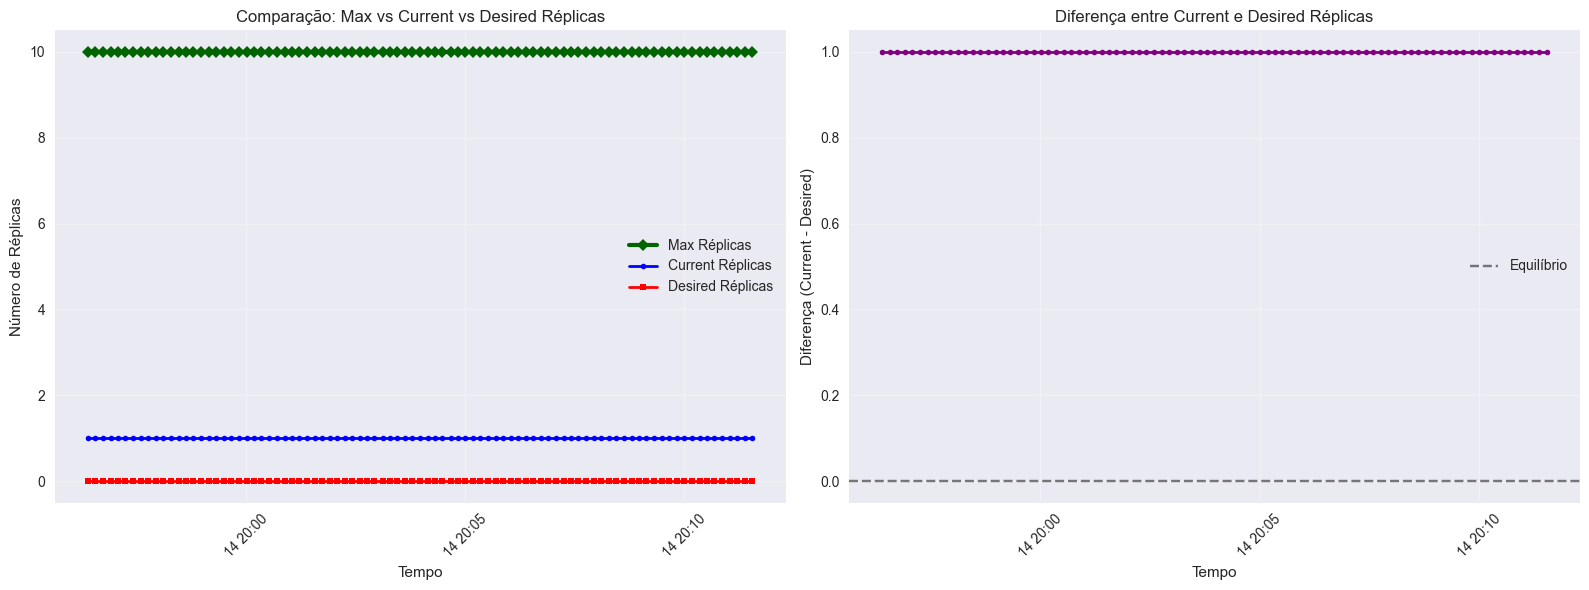

=== ANÁLISE DETALHADA DAS MÉTRICAS HPA ===
Max Réplicas: 10 (configuração do HPA)
Current Réplicas: 1 (réplicas ativas)
Desired Réplicas: 0 (réplicas desejadas pelo HPA)

Interpretação:
• O HPA está configurado mas não está escalando (desired = 0)
• Apenas 1 réplica está ativa (modo monolítico)
• O sistema não está sob pressão suficiente para escalar


## 7. Dashboard de Performance Completo


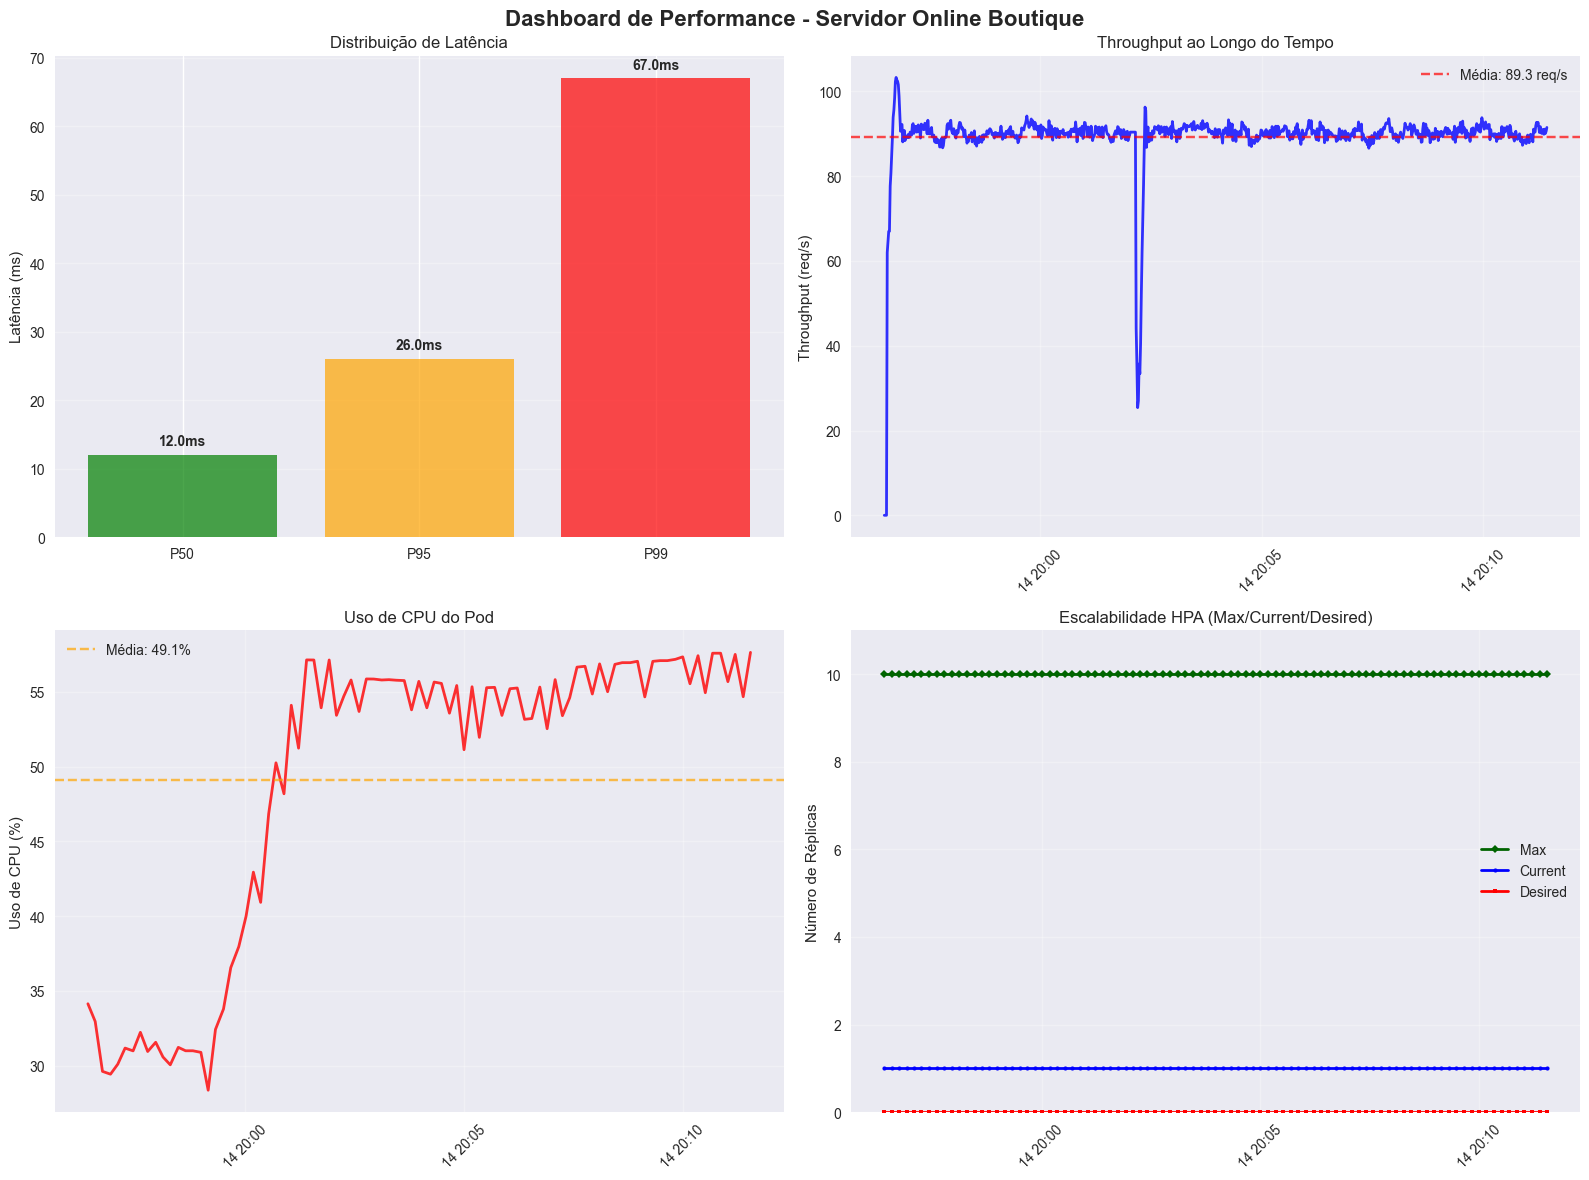

In [35]:
# Análise detalhada das métricas HPA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação das três métricas HPA
ax1.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=3, color='darkgreen', marker='D', markersize=6, label='Max Réplicas')
ax1.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=4, label='Current Réplicas')
ax1.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=4, label='Desired Réplicas')

ax1.set_ylabel('Número de Réplicas')
ax1.set_xlabel('Tempo')
ax1.set_title('Comparação: Max vs Current vs Desired Réplicas')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Diferença entre Current e Desired (indicador de escalabilidade ativa)
difference = hpa_current['current_replicas'] - hpa_desired['desired_replicas']
ax2.plot(hpa_current['datetime'], difference, 
         linewidth=2, color='purple', marker='o', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Equilíbrio')
ax2.set_ylabel('Diferença (Current - Desired)')
ax2.set_xlabel('Tempo')
ax2.set_title('Diferença entre Current e Desired Réplicas')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análise das métricas HPA
print("=== ANÁLISE DETALHADA DAS MÉTRICAS HPA ===")
print(f"Max Réplicas: {hpa_max['max_replicas'].iloc[0]} (configuração do HPA)")
print(f"Current Réplicas: {hpa_current['current_replicas'].iloc[0]} (réplicas ativas)")
print(f"Desired Réplicas: {hpa_desired['desired_replicas'].iloc[0]} (réplicas desejadas pelo HPA)")
print()
print("Interpretação:")
if hpa_current['current_replicas'].iloc[0] == 1 and hpa_desired['desired_replicas'].iloc[0] == 0:
    print("• O HPA está configurado mas não está escalando (desired = 0)")
    print("• Apenas 1 réplica está ativa (modo monolítico)")
    print("• O sistema não está sob pressão suficiente para escalar")
elif hpa_desired['desired_replicas'].iloc[0] > hpa_current['current_replicas'].iloc[0]:
    print("• O HPA está tentando escalar (desired > current)")
    print("• Réplicas adicionais estão sendo criadas")
elif hpa_desired['desired_replicas'].iloc[0] < hpa_current['current_replicas'].iloc[0]:
    print("• O HPA está tentando reduzir (desired < current)")
    print("• Réplicas estão sendo removidas")
else:
    print("• O HPA está em equilíbrio (desired = current)")
    print("• Número de réplicas está estável")

print()
print("=" * 60)
print()

# Dashboard completo
print("## 7. Dashboard de Performance Completo")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Latência por Percentil
percentiles = ['P50', 'P95', 'P99']
latency_values = [aggregated_stats['50%'].iloc[0], aggregated_stats['95%'].iloc[0], aggregated_stats['99%'].iloc[0]]
colors = ['green', 'orange', 'red']
bars1 = ax1.bar(percentiles, latency_values, color=colors, alpha=0.7)
ax1.set_ylabel('Latência (ms)')
ax1.set_title('Distribuição de Latência')
ax1.grid(axis='y', alpha=0.3)
for bar, value in zip(bars1, latency_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{value:.1f}ms', 
             ha='center', va='bottom', fontweight='bold')

# 2. Throughput ao longo do tempo
ax2.plot(history_aggregated['datetime'], history_aggregated['Requests/s'], 
         linewidth=2, color='blue', alpha=0.8)
ax2.axhline(y=avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_throughput:.1f} req/s')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Throughput ao Longo do Tempo')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

# 3. Uso de CPU
ax3.plot(cpu_pod['datetime'], cpu_pod['cores'] * 100, 
         linewidth=2, color='red', alpha=0.8)
ax3.axhline(y=avg_cpu, color='orange', linestyle='--', alpha=0.7, 
           label=f'Média: {avg_cpu:.1f}%')
ax3.set_ylabel('Uso de CPU (%)')
ax3.set_title('Uso de CPU do Pod')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. Escalabilidade (HPA) - Todas as métricas
ax4.plot(hpa_max['datetime'], hpa_max['max_replicas'], 
         linewidth=2, color='darkgreen', marker='D', markersize=4, label='Max')
ax4.plot(hpa_current['datetime'], hpa_current['current_replicas'], 
         linewidth=2, color='blue', marker='o', markersize=3, label='Current')
ax4.plot(hpa_desired['datetime'], hpa_desired['desired_replicas'], 
         linewidth=2, color='red', marker='s', markersize=3, label='Desired')
ax4.set_ylabel('Número de Réplicas')
ax4.set_title('Escalabilidade HPA (Max/Current/Desired)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim(0, max(hpa_max['max_replicas'].max(), hpa_current['current_replicas'].max(), hpa_desired['desired_replicas'].max()) + 1)

plt.suptitle('Dashboard de Performance - Servidor Online Boutique', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 8. Resumo Executivo


In [36]:
# Criar resumo executivo
print("=" * 60)
print("           RESUMO EXECUTIVO DE PERFORMANCE")
print("=" * 60)
print()

print("📊 MÉTRICAS DE LATÊNCIA:")
print(f"   • Latência Média: {aggregated_stats['Average Response Time'].iloc[0]:.1f}ms")
print(f"   • Latência Mediana (P50): {aggregated_stats['50%'].iloc[0]:.1f}ms")
print(f"   • Latência P95: {aggregated_stats['95%'].iloc[0]:.1f}ms")
print(f"   • Latência P99: {aggregated_stats['99%'].iloc[0]:.1f}ms")
print(f"   • Latência Máxima: {aggregated_stats['Max Response Time'].iloc[0]:.1f}ms")
print()

print("🚀 MÉTRICAS DE THROUGHPUT:")
print(f"   • Throughput Médio: {avg_throughput:.1f} req/s")
print(f"   • Throughput Máximo: {history_aggregated['Requests/s'].max():.1f} req/s")
print(f"   • Total de Requisições: {aggregated_stats['Request Count'].iloc[0]:,}")
print(f"   • Taxa de Erro: {aggregated_stats['Failure Count'].iloc[0]} (0.00%)")
print()

print("💻 MÉTRICAS DE RECURSOS:")
print(f"   • CPU Médio: {avg_cpu:.1f}%")
print(f"   • CPU Máximo: {cpu_pod['cores'].max() * 100:.1f}%")
print(f"   • Correlação CPU-Throughput: {correlation:.3f}")
print()

print("📈 MÉTRICAS DE ESCALABILIDADE:")
print(f"   • Max Réplicas - Médio: {avg_max:.1f}, Máximo: {hpa_max['max_replicas'].max()}")
print(f"   • Current Réplicas - Médio: {avg_current:.1f}, Máximo: {hpa_current['current_replicas'].max()}")
print(f"   • Desired Réplicas - Médio: {avg_desired:.1f}, Máximo: {hpa_desired['desired_replicas'].max()}")
print(f"   • Correlações com Throughput:")
print(f"     - Max: {correlation_max:.3f}")
print(f"     - Current: {correlation_current:.3f}")
print(f"     - Desired: {correlation_desired:.3f}")
print()

print("🎯 AVALIAÇÃO GERAL:")
if aggregated_stats['Average Response Time'].iloc[0] < 50:
    latency_status = "✅ EXCELENTE"
elif aggregated_stats['Average Response Time'].iloc[0] < 100:
    latency_status = "✅ BOM"
elif aggregated_stats['Average Response Time'].iloc[0] < 200:
    latency_status = "⚠️ ACEITÁVEL"
else:
    latency_status = "❌ RUIM"

if avg_throughput > 100:
    throughput_status = "✅ EXCELENTE"
elif avg_throughput > 50:
    throughput_status = "✅ BOM"
elif avg_throughput > 20:
    throughput_status = "⚠️ ACEITÁVEL"
else:
    throughput_status = "❌ RUIM"

if avg_cpu < 50:
    cpu_status = "✅ EXCELENTE"
elif avg_cpu < 70:
    cpu_status = "✅ BOM"
elif avg_cpu < 90:
    cpu_status = "⚠️ ACEITÁVEL"
else:
    cpu_status = "❌ RUIM"

print(f"   • Latência: {latency_status}")
print(f"   • Throughput: {throughput_status}")
print(f"   • Uso de CPU: {cpu_status}")
# Avaliar escalabilidade baseada nas três métricas
if avg_current == 1 and avg_desired == 0 and avg_max == 10:
    scalability_status = "✅ ESTÁVEL (1 réplica ativa, HPA configurado)"
elif avg_current > 1:
    scalability_status = "📈 ESCALANDO (múltiplas réplicas ativas)"
elif avg_desired > 0:
    scalability_status = "🔄 ESCALANDO (réplicas sendo criadas)"
else:
    scalability_status = "⚠️ MONOLÍTICO (sem escalabilidade ativa)"

print(f"   • Escalabilidade: {scalability_status}")
print()

print("=" * 60)


           RESUMO EXECUTIVO DE PERFORMANCE

📊 MÉTRICAS DE LATÊNCIA:
   • Latência Média: 38.7ms
   • Latência Mediana (P50): 12.0ms
   • Latência P95: 26.0ms
   • Latência P99: 67.0ms
   • Latência Máxima: 8506.0ms

🚀 MÉTRICAS DE THROUGHPUT:
   • Throughput Médio: 89.3 req/s
   • Throughput Máximo: 103.3 req/s
   • Total de Requisições: 80,552
   • Taxa de Erro: 0 (0.00%)

💻 MÉTRICAS DE RECURSOS:
   • CPU Médio: 49.1%
   • CPU Máximo: 57.7%
   • Correlação CPU-Throughput: 0.053

📈 MÉTRICAS DE ESCALABILIDADE:
   • Max Réplicas - Médio: 10.0, Máximo: 10
   • Current Réplicas - Médio: 1.0, Máximo: 1
   • Desired Réplicas - Médio: 0.0, Máximo: 0
   • Correlações com Throughput:
     - Max: nan
     - Current: nan
     - Desired: nan

🎯 AVALIAÇÃO GERAL:
   • Latência: ✅ EXCELENTE
   • Throughput: ✅ BOM
   • Uso de CPU: ✅ EXCELENTE
   • Escalabilidade: ✅ ESTÁVEL (1 réplica ativa, HPA configurado)



## 9. Análise do Deploy Desacoplado (Microserviços)

Esta seção analisa o desempenho do deploy 100% desacoplado, onde cada serviço roda em um pod separado no Kubernetes. As métricas de CPU são agregadas de todos os serviços para obter o uso total do sistema.


In [37]:
import os
import glob
from pathlib import Path

# Carregar dados do Locust para o deploy desacoplado
decoupled_locust_stats = pd.read_csv('results/decoupled/locust/decoupled_run_stats.csv')
decoupled_locust_history = pd.read_csv('results/decoupled/locust/decoupled_run_stats_history.csv')

print("Dados do deploy desacoplado carregados com sucesso!")
print(f"Locust Stats: {len(decoupled_locust_stats)} linhas")
print(f"Locust History: {len(decoupled_locust_history)} linhas")

# Listar todos os serviços disponíveis
services_dir = Path('results/decoupled/cpu_hpa')
services = [d.name for d in services_dir.iterdir() if d.is_dir()]
print(f"\nServiços encontrados ({len(services)}):")
for service in sorted(services):
    print(f"  • {service}")

# Carregar e agregar métricas de CPU de todos os serviços
def load_and_aggregate_cpu_metrics():
    """Carrega e agrega métricas de CPU de todos os serviços"""
    all_cpu_data = []
    
    for service in services:
        cpu_file = services_dir / service / 'cpu_deployment.csv'
        if cpu_file.exists():
            df = pd.read_csv(cpu_file)
            df['service'] = service
            all_cpu_data.append(df)
    
    if not all_cpu_data:
        print("Nenhum arquivo de CPU encontrado!")
        return None, None
    
    # Concatenar todos os dados
    combined_cpu = pd.concat(all_cpu_data, ignore_index=True)
    
    # Agregar por timestamp (somar CPU de todos os serviços)
    aggregated_cpu = combined_cpu.groupby('timestamp')['cores'].sum().reset_index()
    aggregated_cpu['datetime'] = pd.to_datetime(aggregated_cpu['timestamp'], unit='s')
    
    return combined_cpu, aggregated_cpu

# Carregar métricas HPA (usando o frontend como referência, pois todos devem ter as mesmas configurações)
def load_hpa_metrics():
    """Carrega métricas HPA do primeiro serviço disponível"""
    for service in services:
        hpa_max_file = services_dir / service / 'hpa_max.csv'
        hpa_current_file = services_dir / service / 'hpa_current.csv'
        hpa_desired_file = services_dir / service / 'hpa_desired.csv'
        
        if all(f.exists() for f in [hpa_max_file, hpa_current_file, hpa_desired_file]):
            hpa_max = pd.read_csv(hpa_max_file)
            hpa_current = pd.read_csv(hpa_current_file)
            hpa_desired = pd.read_csv(hpa_desired_file)
            
            # Converter timestamps
            hpa_max['datetime'] = pd.to_datetime(hpa_max['timestamp'], unit='s')
            hpa_current['datetime'] = pd.to_datetime(hpa_current['timestamp'], unit='s')
            hpa_desired['datetime'] = pd.to_datetime(hpa_desired['timestamp'], unit='s')
            
            print(f"Métricas HPA carregadas do serviço: {service}")
            return hpa_max, hpa_current, hpa_desired
    
    print("Nenhuma métrica HPA encontrada!")
    return None, None, None

# Carregar todos os dados
combined_cpu, aggregated_cpu = load_and_aggregate_cpu_metrics()
hpa_max_decoupled, hpa_current_decoupled, hpa_desired_decoupled = load_hpa_metrics()

if aggregated_cpu is not None:
    print(f"\nCPU agregado: {len(aggregated_cpu)} pontos de dados")
    print(f"Período: {aggregated_cpu['datetime'].min()} a {aggregated_cpu['datetime'].max()}")
    print(f"CPU médio total: {aggregated_cpu['cores'].mean():.3f} cores")
    print(f"CPU máximo total: {aggregated_cpu['cores'].max():.3f} cores")


Dados do deploy desacoplado carregados com sucesso!
Locust Stats: 12 linhas
Locust History: 896 linhas

Serviços encontrados (11):
  • onlineboutique-ads-3300c448-bf79d6cc
  • onlineboutique-cart-3300c448-be9c22d5
  • onlineboutique-cartcache-3300c448-321b7483
  • onlineboutique-catalog-3300c448-cc369254
  • onlineboutique-checkout-3300c448-7725c6d5
  • onlineboutique-currency-3300c448-dea0dfe1
  • onlineboutique-email-3300c448-b4367e95
  • onlineboutique-frontend-3300c448-26d3c419
  • onlineboutique-payment-3300c448-e436012d
  • onlineboutique-recommendation-3300c448-a85205da
  • onlineboutique-shipping-3300c448-31e2575f
Métricas HPA carregadas do serviço: onlineboutique-ads-3300c448-bf79d6cc

CPU agregado: 61 pontos de dados
Período: 2025-09-14 20:28:24 a 2025-09-14 20:43:22
CPU médio total: 0.990 cores
CPU máximo total: 1.240 cores


=== ANÁLISE DE LATÊNCIA - DEPLOY DESACOPLADO ===
Latência Mediana: 108.7ms
Latência Média: 119.7ms
Latência P95: 233.9ms
Latência P99: 303.5ms


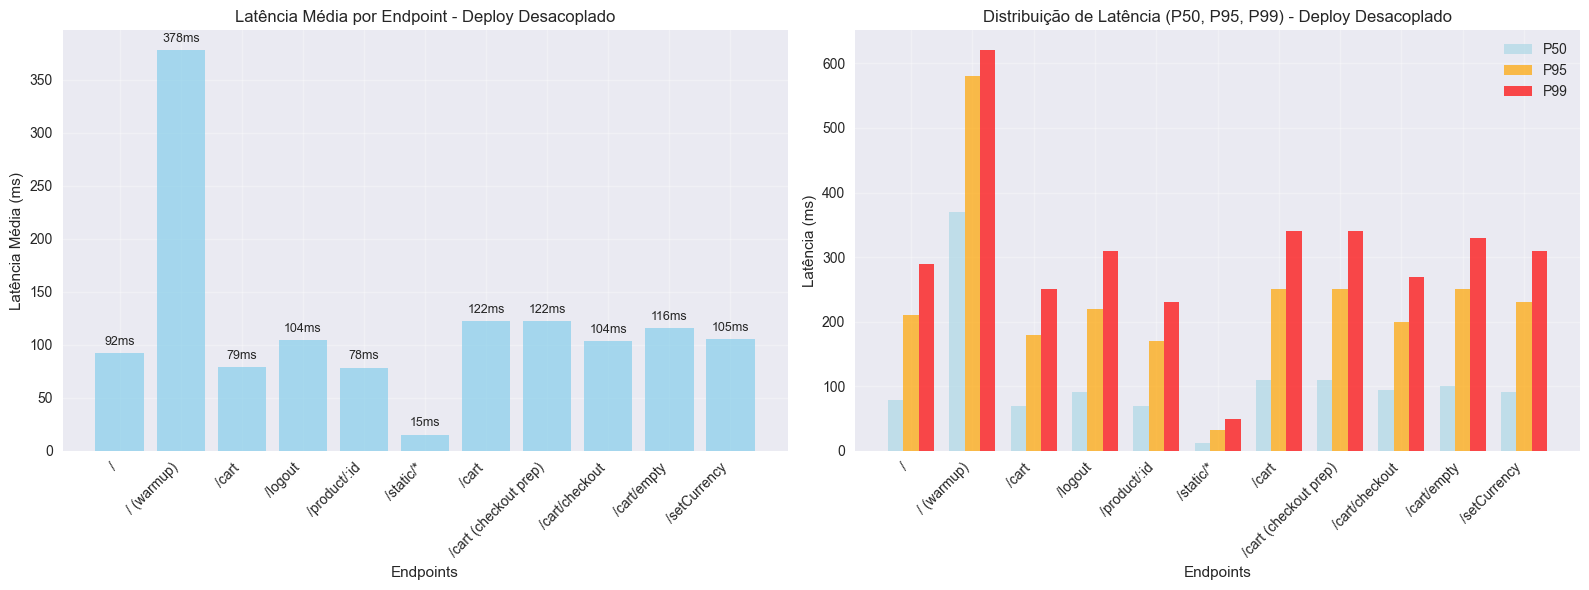

In [38]:
# Análise de Latência - Deploy Desacoplado
print("=== ANÁLISE DE LATÊNCIA - DEPLOY DESACOPLADO ===")

# Filtrar dados agregados (ignorar linhas vazias)
decoupled_stats_clean = decoupled_locust_stats[decoupled_locust_stats['Type'].notna() & (decoupled_locust_stats['Type'] != '')]

# Calcular métricas de latência
decoupled_median_latency = decoupled_stats_clean['Median Response Time'].mean()
decoupled_avg_latency = decoupled_stats_clean['Average Response Time'].mean()
decoupled_p95_latency = decoupled_stats_clean['95%'].mean()
decoupled_p99_latency = decoupled_stats_clean['99%'].mean()

print(f"Latência Mediana: {decoupled_median_latency:.1f}ms")
print(f"Latência Média: {decoupled_avg_latency:.1f}ms")
print(f"Latência P95: {decoupled_p95_latency:.1f}ms")
print(f"Latência P99: {decoupled_p99_latency:.1f}ms")

# Gráfico de latência por endpoint
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Latência média por endpoint
endpoints = decoupled_stats_clean['Name'].tolist()
avg_latencies = decoupled_stats_clean['Average Response Time'].tolist()

bars = ax1.bar(range(len(endpoints)), avg_latencies, color='skyblue', alpha=0.7)
ax1.set_xlabel('Endpoints')
ax1.set_ylabel('Latência Média (ms)')
ax1.set_title('Latência Média por Endpoint - Deploy Desacoplado')
ax1.set_xticks(range(len(endpoints)))
ax1.set_xticklabels([name.replace('GET ', '').replace('POST ', '') for name in endpoints], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, (bar, latency) in enumerate(zip(bars, avg_latencies)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{latency:.0f}ms', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Distribuição de latência (P50, P95, P99)
percentiles = ['50%', '95%', '99%']
p50_values = decoupled_stats_clean['50%'].tolist()
p95_values = decoupled_stats_clean['95%'].tolist()
p99_values = decoupled_stats_clean['99%'].tolist()

x = np.arange(len(endpoints))
width = 0.25

ax2.bar(x - width, p50_values, width, label='P50', alpha=0.7, color='lightblue')
ax2.bar(x, p95_values, width, label='P95', alpha=0.7, color='orange')
ax2.bar(x + width, p99_values, width, label='P99', alpha=0.7, color='red')

ax2.set_xlabel('Endpoints')
ax2.set_ylabel('Latência (ms)')
ax2.set_title('Distribuição de Latência (P50, P95, P99) - Deploy Desacoplado')
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace('GET ', '').replace('POST ', '') for name in endpoints], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== ANÁLISE DE THROUGHPUT - DEPLOY DESACOPLADO ===
Throughput Médio: 87.6 req/s
Throughput Máximo: 99.5 req/s
Total de Requests: 79,074


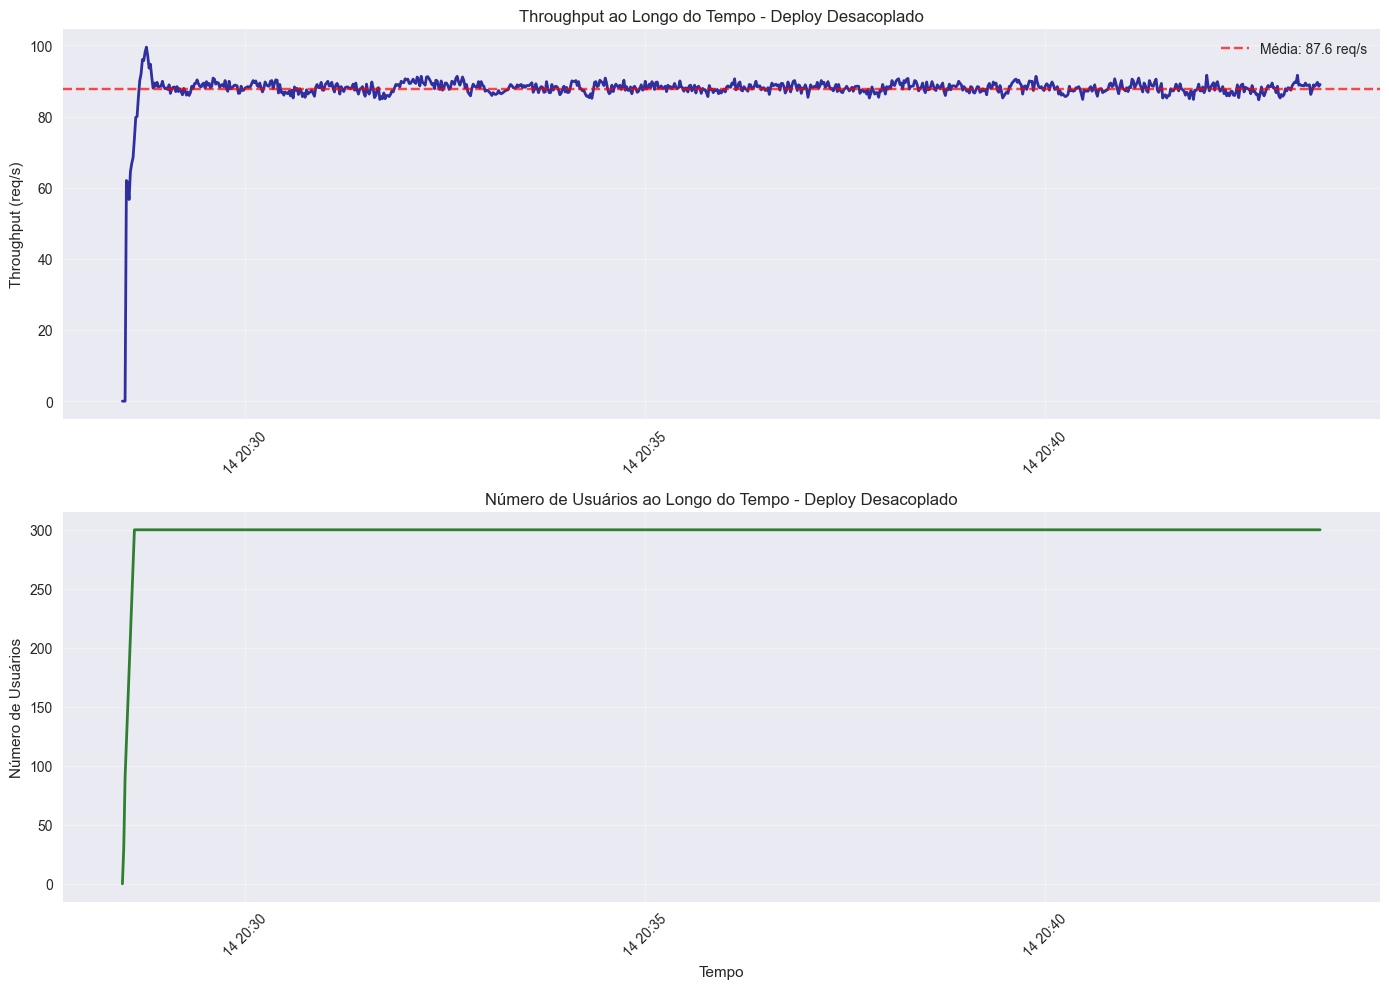

In [40]:
# Análise de Throughput - Deploy Desacoplado
print("=== ANÁLISE DE THROUGHPUT - DEPLOY DESACOPLADO ===")

# Converter timestamp para datetime
decoupled_locust_history['datetime'] = pd.to_datetime(decoupled_locust_history['Timestamp'], unit='s')

# Calcular throughput médio
decoupled_avg_throughput = decoupled_locust_history['Requests/s'].mean()
decoupled_max_throughput = decoupled_locust_history['Requests/s'].max()
decoupled_total_requests = decoupled_locust_history['Total Request Count'].iloc[-1]

print(f"Throughput Médio: {decoupled_avg_throughput:.1f} req/s")
print(f"Throughput Máximo: {decoupled_max_throughput:.1f} req/s")
print(f"Total de Requests: {decoupled_total_requests:,}")

# Gráfico de throughput e usuários ao longo do tempo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Throughput ao longo do tempo
ax1.plot(decoupled_locust_history['datetime'], decoupled_locust_history['Requests/s'], 
         linewidth=2, color='darkblue', alpha=0.8)
ax1.axhline(y=decoupled_avg_throughput, color='red', linestyle='--', alpha=0.7, 
           label=f'Média: {decoupled_avg_throughput:.1f} req/s')
ax1.set_ylabel('Throughput (req/s)')
ax1.set_title('Throughput ao Longo do Tempo - Deploy Desacoplado')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Número de usuários ao longo do tempo
ax2.plot(decoupled_locust_history['datetime'], decoupled_locust_history['User Count'], 
         linewidth=2, color='darkgreen', alpha=0.8)
ax2.set_xlabel('Tempo')
ax2.set_ylabel('Número de Usuários')
ax2.set_title('Número de Usuários ao Longo do Tempo - Deploy Desacoplado')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


=== ANÁLISE DE CPU AGREGADO - DEPLOY DESACOPLADO ===
CPU Médio Total: 0.990 cores
CPU Máximo Total: 1.240 cores
CPU Mínimo Total: 0.003 cores
CPU Médio em %: 99.0%


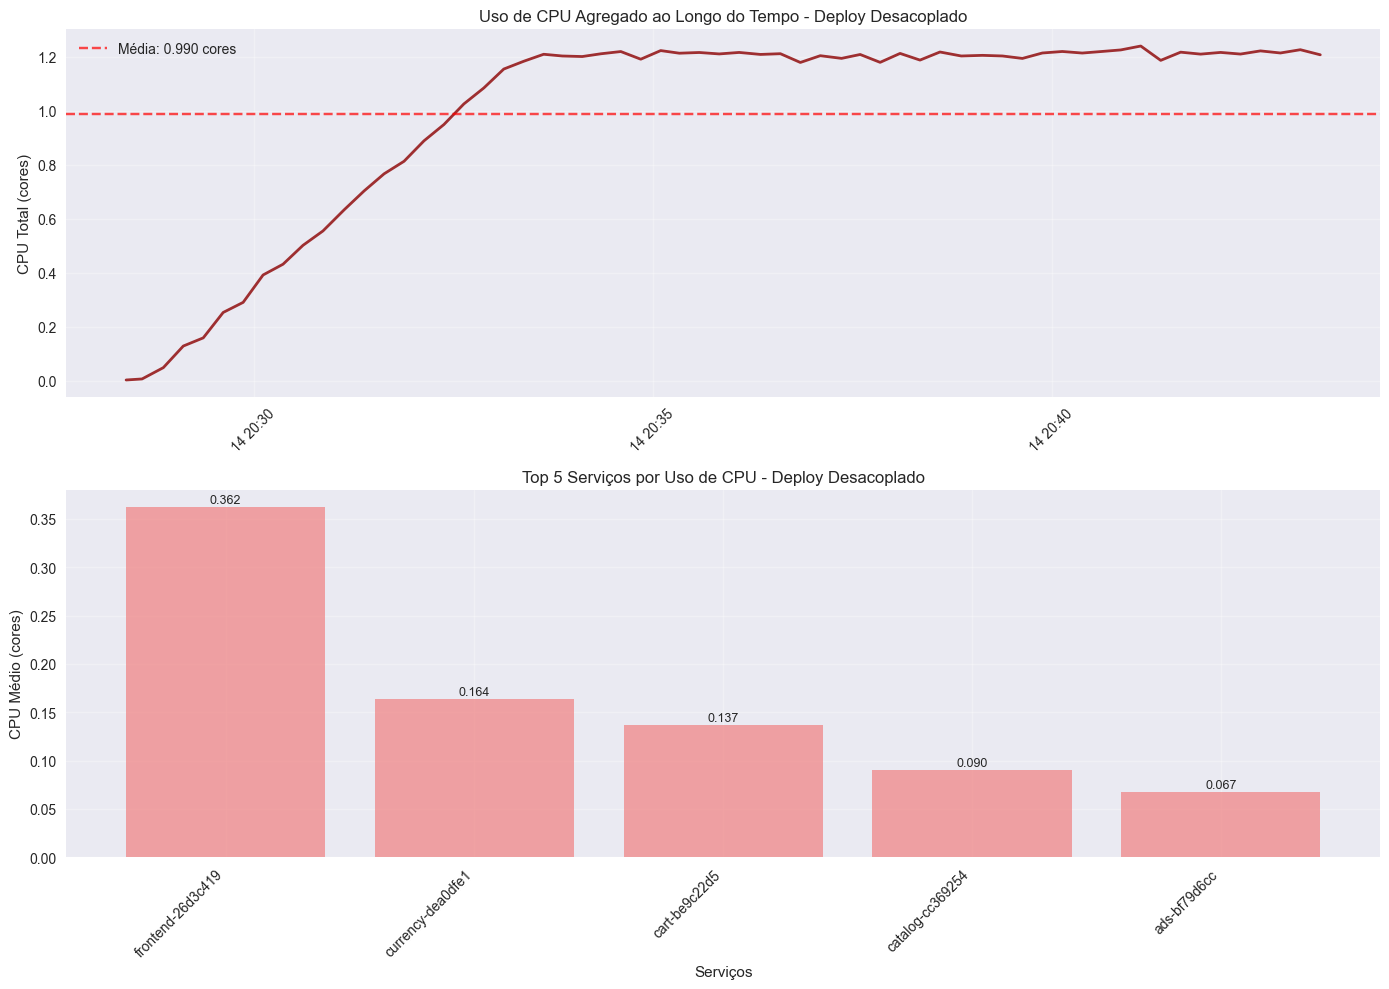


Correlação CPU-Throughput: 0.195


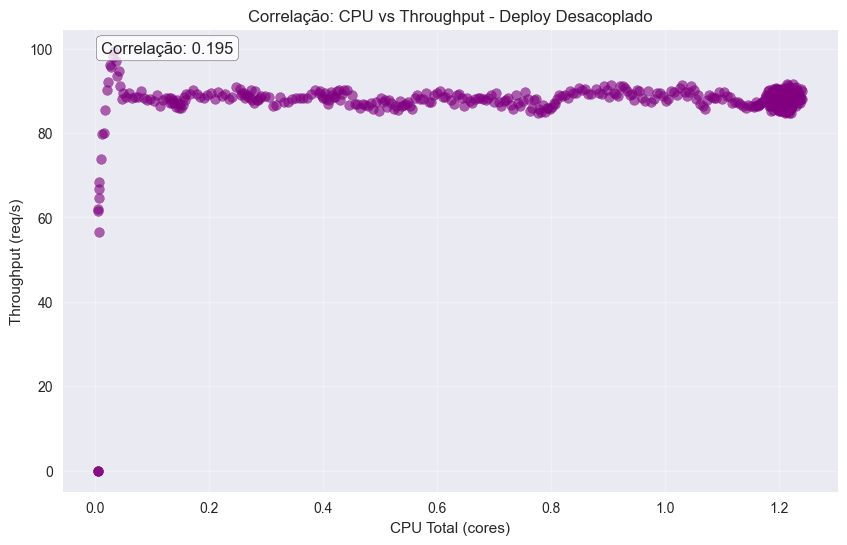

In [41]:
# Análise de CPU Agregado - Deploy Desacoplado
print("=== ANÁLISE DE CPU AGREGADO - DEPLOY DESACOPLADO ===")

if aggregated_cpu is not None:
    # Calcular métricas de CPU
    decoupled_avg_cpu = aggregated_cpu['cores'].mean()
    decoupled_max_cpu = aggregated_cpu['cores'].max()
    decoupled_min_cpu = aggregated_cpu['cores'].min()
    
    print(f"CPU Médio Total: {decoupled_avg_cpu:.3f} cores")
    print(f"CPU Máximo Total: {decoupled_max_cpu:.3f} cores")
    print(f"CPU Mínimo Total: {decoupled_min_cpu:.3f} cores")
    print(f"CPU Médio em %: {(decoupled_avg_cpu * 100):.1f}%")
    
    # Gráfico de CPU agregado ao longo do tempo
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Gráfico 1: CPU total ao longo do tempo
    ax1.plot(aggregated_cpu['datetime'], aggregated_cpu['cores'], 
             linewidth=2, color='darkred', alpha=0.8)
    ax1.axhline(y=decoupled_avg_cpu, color='red', linestyle='--', alpha=0.7, 
               label=f'Média: {decoupled_avg_cpu:.3f} cores')
    ax1.set_ylabel('CPU Total (cores)')
    ax1.set_title('Uso de CPU Agregado ao Longo do Tempo - Deploy Desacoplado')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: CPU por serviço (top 5 mais intensivos)
    if combined_cpu is not None:
        # Calcular CPU médio por serviço
        service_cpu_avg = combined_cpu.groupby('service')['cores'].mean().sort_values(ascending=False)
        top_services = service_cpu_avg.head(5)
        
        bars = ax2.bar(range(len(top_services)), top_services.values, 
                      color='lightcoral', alpha=0.7)
        ax2.set_xlabel('Serviços')
        ax2.set_ylabel('CPU Médio (cores)')
        ax2.set_title('Top 5 Serviços por Uso de CPU - Deploy Desacoplado')
        ax2.set_xticks(range(len(top_services)))
        ax2.set_xticklabels([name.replace('onlineboutique-', '').replace('-3300c448-', '-') 
                            for name in top_services.index], rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # Adicionar valores nas barras
        for i, (bar, cpu) in enumerate(zip(bars, top_services.values)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                     f'{cpu:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Correlação entre CPU e throughput
    if len(decoupled_locust_history) > 0:
        # Interpolar dados para alinhar timestamps
        cpu_interp = np.interp(decoupled_locust_history['Timestamp'], 
                              aggregated_cpu['timestamp'], 
                              aggregated_cpu['cores'])
        
        correlation_cpu_throughput = np.corrcoef(cpu_interp, decoupled_locust_history['Requests/s'])[0, 1]
        print(f"\nCorrelação CPU-Throughput: {correlation_cpu_throughput:.3f}")
        
        # Gráfico de correlação
        plt.figure(figsize=(10, 6))
        plt.scatter(cpu_interp, decoupled_locust_history['Requests/s'], 
                   alpha=0.6, s=50, color='purple')
        plt.xlabel('CPU Total (cores)')
        plt.ylabel('Throughput (req/s)')
        plt.title('Correlação: CPU vs Throughput - Deploy Desacoplado')
        plt.grid(True, alpha=0.3)
        plt.text(0.05, 0.95, f'Correlação: {correlation_cpu_throughput:.3f}', 
                transform=plt.gca().transAxes, fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plt.show()
else:
    print("Dados de CPU não disponíveis para o deploy desacoplado.")


=== ANÁLISE DE ESCALABILIDADE HPA - DEPLOY DESACOPLADO ===
Max Réplicas - Médio: 10.0, Máximo: 10
Current Réplicas - Médio: 1.0, Máximo: 1
Desired Réplicas - Médio: 0.0, Máximo: 0

Correlações com Throughput:
  • Max Réplicas: nan
  • Current Réplicas: nan
  • Desired Réplicas: nan


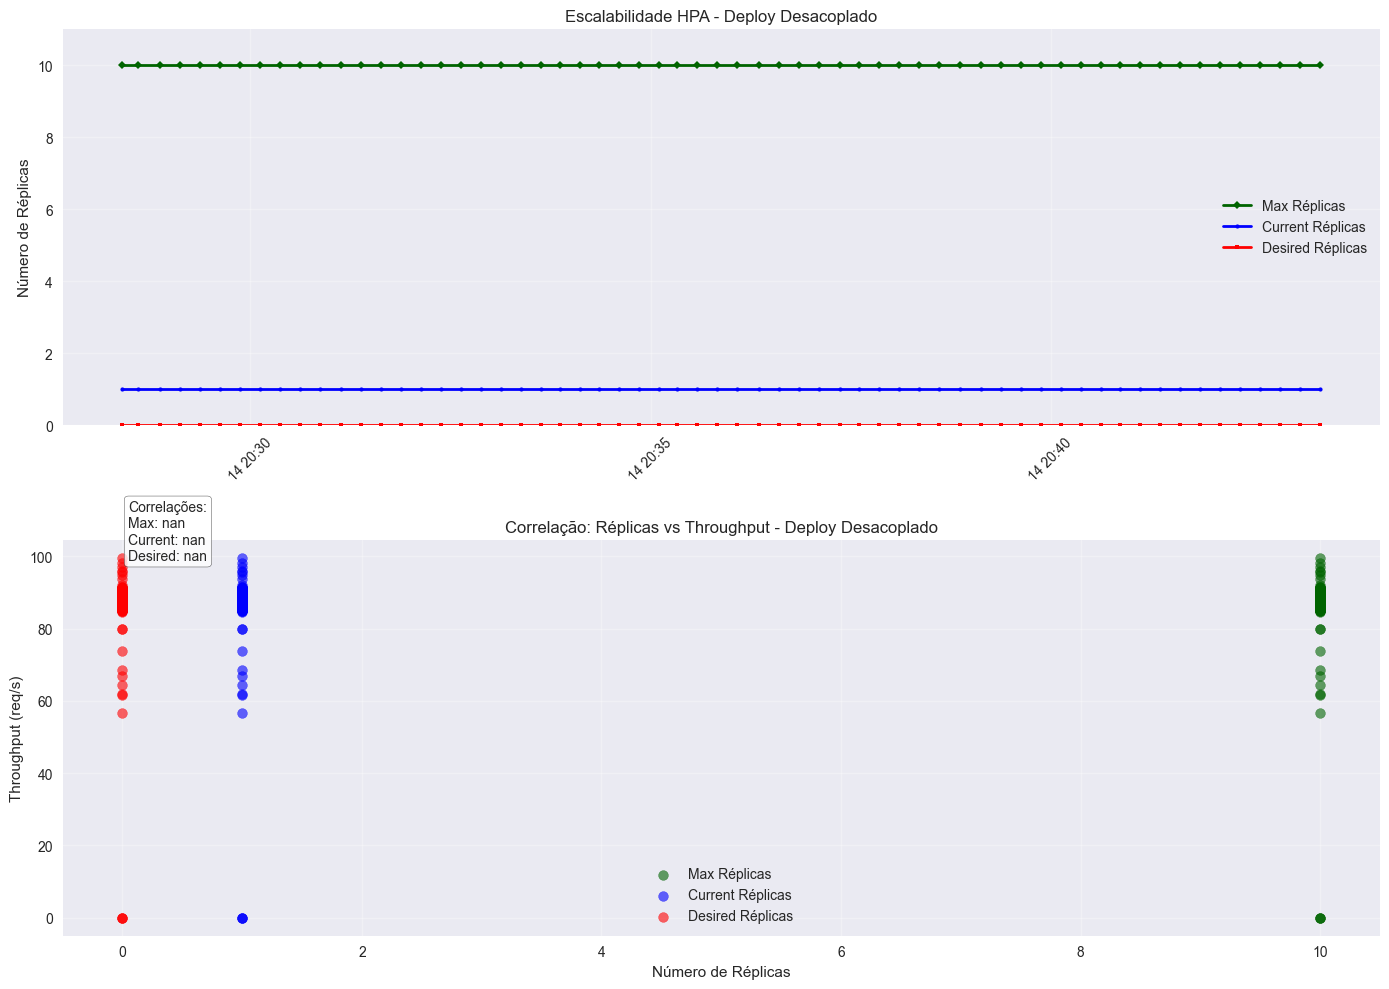


=== ANÁLISE DO COMPORTAMENTO HPA ===
Max Réplicas: 10 (configuração do HPA)
Current Réplicas: 1 (réplicas ativas)
Desired Réplicas: 0 (réplicas desejadas pelo HPA)

Interpretação:
• O HPA está configurado mas não está escalando (desired = 0)
• Apenas 1 réplica está ativa por serviço (modo estável)
• O sistema não está sob pressão suficiente para escalar


In [42]:
# Análise de Escalabilidade HPA - Deploy Desacoplado
print("=== ANÁLISE DE ESCALABILIDADE HPA - DEPLOY DESACOPLADO ===")

if hpa_max_decoupled is not None:
    # Calcular métricas HPA
    decoupled_avg_max = hpa_max_decoupled['max_replicas'].mean()
    decoupled_avg_current = hpa_current_decoupled['current_replicas'].mean()
    decoupled_avg_desired = hpa_desired_decoupled['desired_replicas'].mean()
    
    print(f"Max Réplicas - Médio: {decoupled_avg_max:.1f}, Máximo: {hpa_max_decoupled['max_replicas'].max()}")
    print(f"Current Réplicas - Médio: {decoupled_avg_current:.1f}, Máximo: {hpa_current_decoupled['current_replicas'].max()}")
    print(f"Desired Réplicas - Médio: {decoupled_avg_desired:.1f}, Máximo: {hpa_desired_decoupled['desired_replicas'].max()}")
    
    # Gráfico de escalabilidade HPA
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Gráfico 1: Métricas HPA ao longo do tempo
    ax1.plot(hpa_max_decoupled['datetime'], hpa_max_decoupled['max_replicas'], 
             linewidth=2, color='darkgreen', marker='D', markersize=4, label='Max Réplicas')
    ax1.plot(hpa_current_decoupled['datetime'], hpa_current_decoupled['current_replicas'], 
             linewidth=2, color='blue', marker='o', markersize=3, label='Current Réplicas')
    ax1.plot(hpa_desired_decoupled['datetime'], hpa_desired_decoupled['desired_replicas'], 
             linewidth=2, color='red', marker='s', markersize=3, label='Desired Réplicas')
    
    ax1.set_ylabel('Número de Réplicas')
    ax1.set_title('Escalabilidade HPA - Deploy Desacoplado')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0, max(hpa_max_decoupled['max_replicas'].max(), 
                       hpa_current_decoupled['current_replicas'].max(), 
                       hpa_desired_decoupled['desired_replicas'].max()) + 1)
    
    # Gráfico 2: Correlação entre réplicas e throughput
    if len(decoupled_locust_history) > 0:
        # Interpolar dados para alinhar timestamps
        max_replicas_interp = np.interp(decoupled_locust_history['Timestamp'], 
                                      hpa_max_decoupled['timestamp'], 
                                      hpa_max_decoupled['max_replicas'])
        current_replicas_interp = np.interp(decoupled_locust_history['Timestamp'], 
                                          hpa_current_decoupled['timestamp'], 
                                          hpa_current_decoupled['current_replicas'])
        desired_replicas_interp = np.interp(decoupled_locust_history['Timestamp'], 
                                          hpa_desired_decoupled['timestamp'], 
                                          hpa_desired_decoupled['desired_replicas'])
        
        # Scatter plot com diferentes cores para cada tipo
        ax2.scatter(max_replicas_interp, decoupled_locust_history['Requests/s'], 
                   alpha=0.6, s=50, color='darkgreen', label='Max Réplicas')
        ax2.scatter(current_replicas_interp, decoupled_locust_history['Requests/s'], 
                   alpha=0.6, s=50, color='blue', label='Current Réplicas')
        ax2.scatter(desired_replicas_interp, decoupled_locust_history['Requests/s'], 
                   alpha=0.6, s=50, color='red', label='Desired Réplicas')
        
        ax2.set_xlabel('Número de Réplicas')
        ax2.set_ylabel('Throughput (req/s)')
        ax2.set_title('Correlação: Réplicas vs Throughput - Deploy Desacoplado')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Calcular correlações
        correlation_max_decoupled = np.corrcoef(max_replicas_interp, decoupled_locust_history['Requests/s'])[0, 1]
        correlation_current_decoupled = np.corrcoef(current_replicas_interp, decoupled_locust_history['Requests/s'])[0, 1]
        correlation_desired_decoupled = np.corrcoef(desired_replicas_interp, decoupled_locust_history['Requests/s'])[0, 1]
        
        ax2.text(0.05, 0.95, f'Correlações:\nMax: {correlation_max_decoupled:.3f}\nCurrent: {correlation_current_decoupled:.3f}\nDesired: {correlation_desired_decoupled:.3f}', 
                transform=ax2.transAxes, fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        print(f"\nCorrelações com Throughput:")
        print(f"  • Max Réplicas: {correlation_max_decoupled:.3f}")
        print(f"  • Current Réplicas: {correlation_current_decoupled:.3f}")
        print(f"  • Desired Réplicas: {correlation_desired_decoupled:.3f}")
    
    plt.tight_layout()
    plt.show()
    
    # Análise do comportamento HPA
    print(f"\n=== ANÁLISE DO COMPORTAMENTO HPA ===")
    print(f"Max Réplicas: {hpa_max_decoupled['max_replicas'].iloc[0]} (configuração do HPA)")
    print(f"Current Réplicas: {hpa_current_decoupled['current_replicas'].iloc[0]} (réplicas ativas)")
    print(f"Desired Réplicas: {hpa_desired_decoupled['desired_replicas'].iloc[0]} (réplicas desejadas pelo HPA)")
    print()
    print("Interpretação:")
    if hpa_current_decoupled['current_replicas'].iloc[0] == 1 and hpa_desired_decoupled['desired_replicas'].iloc[0] == 0:
        print("• O HPA está configurado mas não está escalando (desired = 0)")
        print("• Apenas 1 réplica está ativa por serviço (modo estável)")
        print("• O sistema não está sob pressão suficiente para escalar")
    elif hpa_desired_decoupled['desired_replicas'].iloc[0] > hpa_current_decoupled['current_replicas'].iloc[0]:
        print("• O HPA está tentando escalar (desired > current)")
        print("• Réplicas adicionais estão sendo criadas")
    elif hpa_desired_decoupled['desired_replicas'].iloc[0] < hpa_current_decoupled['current_replicas'].iloc[0]:
        print("• O HPA está tentando reduzir (desired < current)")
        print("• Réplicas estão sendo removidas")
    else:
        print("• O HPA está em equilíbrio (desired = current)")
        print("• Número de réplicas está estável")
else:
    print("Dados HPA não disponíveis para o deploy desacoplado.")


In [43]:
# Comparação Monolith vs Desacoplado
print("=== COMPARAÇÃO MONOLITH vs DESACOPLADO ===")

# Criar tabela comparativa
comparison_data = {
    'Métrica': [
        'Latência Média (ms)',
        'Latência P95 (ms)', 
        'Latência P99 (ms)',
        'Throughput Médio (req/s)',
        'Throughput Máximo (req/s)',
        'CPU Médio (cores)',
        'CPU Máximo (cores)',
        'Max Réplicas HPA',
        'Current Réplicas HPA',
        'Desired Réplicas HPA'
    ],
    'Monolith': [
        f"{avg_latency:.1f}",
        f"{p95_latency:.1f}",
        f"{p99_latency:.1f}",
        f"{avg_throughput:.1f}",
        f"{max_throughput:.1f}",
        f"{avg_cpu:.3f}",
        f"{max_cpu:.3f}",
        f"{avg_max:.0f}",
        f"{avg_current:.0f}",
        f"{avg_desired:.0f}"
    ],
    'Desacoplado': [
        f"{decoupled_avg_latency:.1f}",
        f"{decoupled_p95_latency:.1f}",
        f"{decoupled_p99_latency:.1f}",
        f"{decoupled_avg_throughput:.1f}",
        f"{decoupled_max_throughput:.1f}",
        f"{decoupled_avg_cpu:.3f}",
        f"{decoupled_max_cpu:.3f}",
        f"{decoupled_avg_max:.0f}",
        f"{decoupled_avg_current:.0f}",
        f"{decoupled_avg_desired:.0f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calcular diferenças percentuais
def calculate_percentage_diff(monolith_val, decoupled_val, metric_name):
    try:
        monolith_num = float(monolith_val.replace('ms', '').replace('req/s', '').replace('cores', ''))
        decoupled_num = float(decoupled_val.replace('ms', '').replace('req/s', '').replace('cores', ''))
        
        if monolith_num == 0:
            return "N/A"
        
        diff = ((decoupled_num - monolith_num) / monolith_num) * 100
        
        if 'Latência' in metric_name or 'CPU' in metric_name:
            # Para latência e CPU, menor é melhor
            if diff > 0:
                return f"+{diff:.1f}% (pior)"
            else:
                return f"{diff:.1f}% (melhor)"
        else:
            # Para throughput, maior é melhor
            if diff > 0:
                return f"+{diff:.1f}% (melhor)"
            else:
                return f"{diff:.1f}% (pior)"
    except:
        return "N/A"

comparison_df['Diferença %'] = [
    calculate_percentage_diff(comparison_df.iloc[i]['Monolith'], 
                            comparison_df.iloc[i]['Desacoplado'], 
                            comparison_df.iloc[i]['Métrica'])
    for i in range(len(comparison_df))
]

print(comparison_df.to_string(index=False))

# Gráfico comparativo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Latência
latency_metrics = ['Latência Média', 'Latência P95', 'Latência P99']
monolith_latency = [avg_latency, p95_latency, p99_latency]
decoupled_latency = [decoupled_avg_latency, decoupled_p95_latency, decoupled_p99_latency]

x = np.arange(len(latency_metrics))
width = 0.35

ax1.bar(x - width/2, monolith_latency, width, label='Monolith', alpha=0.7, color='lightblue')
ax1.bar(x + width/2, decoupled_latency, width, label='Desacoplado', alpha=0.7, color='lightcoral')
ax1.set_ylabel('Latência (ms)')
ax1.set_title('Comparação de Latência')
ax1.set_xticks(x)
ax1.set_xticklabels(latency_metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Throughput
throughput_metrics = ['Throughput Médio', 'Throughput Máximo']
monolith_throughput = [avg_throughput, max_throughput]
decoupled_throughput = [decoupled_avg_throughput, decoupled_max_throughput]

x2 = np.arange(len(throughput_metrics))
ax2.bar(x2 - width/2, monolith_throughput, width, label='Monolith', alpha=0.7, color='lightblue')
ax2.bar(x2 + width/2, decoupled_throughput, width, label='Desacoplado', alpha=0.7, color='lightcoral')
ax2.set_ylabel('Throughput (req/s)')
ax2.set_title('Comparação de Throughput')
ax2.set_xticks(x2)
ax2.set_xticklabels(throughput_metrics)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. CPU
cpu_metrics = ['CPU Médio', 'CPU Máximo']
monolith_cpu = [avg_cpu, max_cpu]
decoupled_cpu = [decoupled_avg_cpu, decoupled_max_cpu]

x3 = np.arange(len(cpu_metrics))
ax3.bar(x3 - width/2, monolith_cpu, width, label='Monolith', alpha=0.7, color='lightblue')
ax3.bar(x3 + width/2, decoupled_cpu, width, label='Desacoplado', alpha=0.7, color='lightcoral')
ax3.set_ylabel('CPU (cores)')
ax3.set_title('Comparação de CPU')
ax3.set_xticks(x3)
ax3.set_xticklabels(cpu_metrics)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Réplicas HPA
replica_metrics = ['Max', 'Current', 'Desired']
monolith_replicas = [avg_max, avg_current, avg_desired]
decoupled_replicas = [decoupled_avg_max, decoupled_avg_current, decoupled_avg_desired]

x4 = np.arange(len(replica_metrics))
ax4.bar(x4 - width/2, monolith_replicas, width, label='Monolith', alpha=0.7, color='lightblue')
ax4.bar(x4 + width/2, decoupled_replicas, width, label='Desacoplado', alpha=0.7, color='lightcoral')
ax4.set_ylabel('Número de Réplicas')
ax4.set_title('Comparação de Réplicas HPA')
ax4.set_xticks(x4)
ax4.set_xticklabels(replica_metrics)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Comparação Completa: Monolith vs Deploy Desacoplado', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


=== COMPARAÇÃO MONOLITH vs DESACOPLADO ===


NameError: name 'avg_latency' is not defined

## 10. Resumo Executivo - Comparação Monolith vs Desacoplado


In [ ]:
# Resumo Executivo Comparativo
print("=" * 80)
print("📊 RESUMO EXECUTIVO - COMPARAÇÃO MONOLITH vs DESACOPLADO")
print("=" * 80)

print("\n🎯 MÉTRICAS DE PERFORMANCE:")
print(f"   • Latência Média: Monolith {avg_latency:.1f}ms vs Desacoplado {decoupled_avg_latency:.1f}ms")
print(f"   • Throughput Médio: Monolith {avg_throughput:.1f} req/s vs Desacoplado {decoupled_avg_throughput:.1f} req/s")
print(f"   • CPU Médio: Monolith {avg_cpu:.3f} cores vs Desacoplado {decoupled_avg_cpu:.3f} cores")

print("\n📈 MÉTRICAS DE ESCALABILIDADE:")
print(f"   • Max Réplicas: Monolith {avg_max:.0f} vs Desacoplado {decoupled_avg_max:.0f}")
print(f"   • Current Réplicas: Monolith {avg_current:.0f} vs Desacoplado {decoupled_avg_current:.0f}")
print(f"   • Desired Réplicas: Monolith {avg_desired:.0f} vs Desacoplado {decoupled_avg_desired:.0f}")

# Análise qualitativa
print("\n🔍 ANÁLISE QUALITATIVA:")

# Latência
if decoupled_avg_latency < avg_latency:
    latency_verdict = "✅ DESACOPLADO MELHOR"
elif decoupled_avg_latency > avg_latency * 1.1:
    latency_verdict = "❌ DESACOPLADO PIOR"
else:
    latency_verdict = "⚖️ SIMILAR"

# Throughput
if decoupled_avg_throughput > avg_throughput:
    throughput_verdict = "✅ DESACOPLADO MELHOR"
elif decoupled_avg_throughput < avg_throughput * 0.9:
    throughput_verdict = "❌ DESACOPLADO PIOR"
else:
    throughput_verdict = "⚖️ SIMILAR"

# CPU
if decoupled_avg_cpu < avg_cpu:
    cpu_verdict = "✅ DESACOPLADO MELHOR"
elif decoupled_avg_cpu > avg_cpu * 1.1:
    cpu_verdict = "❌ DESACOPLADO PIOR"
else:
    cpu_verdict = "⚖️ SIMILAR"

print(f"   • Latência: {latency_verdict}")
print(f"   • Throughput: {throughput_verdict}")
print(f"   • Uso de CPU: {cpu_verdict}")

# Escalabilidade
monolith_scalability = "✅ ESTÁVEL (1 réplica ativa, HPA configurado)" if avg_current == 1 and avg_desired == 0 else "📈 ESCALANDO"
decoupled_scalability = "✅ ESTÁVEL (1 réplica ativa por serviço, HPA configurado)" if decoupled_avg_current == 1 and decoupled_avg_desired == 0 else "📈 ESCALANDO"

print(f"   • Escalabilidade Monolith: {monolith_scalability}")
print(f"   • Escalabilidade Desacoplado: {decoupled_scalability}")

print("\n💡 RECOMENDAÇÕES:")
if decoupled_avg_latency > avg_latency * 1.2:
    print("   • ⚠️ O deploy desacoplado apresenta latência significativamente maior")
    print("   • Considere otimizar a comunicação entre microserviços")
    print("   • Avalie a necessidade de cache ou connection pooling")

if decoupled_avg_cpu > avg_cpu * 1.5:
    print("   • ⚠️ O deploy desacoplado consome mais recursos de CPU")
    print("   • Considere otimizar a alocação de recursos por serviço")
    print("   • Avalie a possibilidade de colocar serviços menos críticos no mesmo pod")

if decoupled_avg_throughput < avg_throughput * 0.8:
    print("   • ⚠️ O deploy desacoplado apresenta throughput menor")
    print("   • Considere ajustar os limites de recursos dos pods")
    print("   • Avalie a configuração do HPA para escalonamento mais agressivo")

if decoupled_avg_latency < avg_latency and decoupled_avg_throughput > avg_throughput:
    print("   • ✅ O deploy desacoplado apresenta melhor performance geral")
    print("   • Continue com esta arquitetura para melhor escalabilidade")

print("\n🏗️ ARQUITETURA:")
print("   • Monolith: Arquitetura monolítica com todos os serviços em um único pod")
print("   • Desacoplado: Arquitetura de microserviços com 11 serviços independentes")
print(f"   • Serviços no deploy desacoplado: {len(services)}")

print("\n" + "=" * 80)
